In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

<font size='6' color='red'><b>ch8 트랜스포머(영화표감상분석)</b></font>
- imdb 사이트의 5만개 영화 감상평

# 1. 패키지 import

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 학습하는 속도에 차이가 난다

In [3]:
MY_WORDS = 20000 # imdb 데이터 안의 단어수
MY_LENGTH  = 200 # 독립변수 차원 (영화평 단어수 80개로 맞출 예정)
MY_EMBED = 32   # Embedding 결과 차원
MY_HIDDEN = 64 # LSTM units 수

MY_EPOCH = 15 # fit 반복학습 수
MY_BATCH = 200 # 배치사이즈(fit할때, 매번 가져오는 데이터 수)

# 불용어 설정 (빈도수가 높은 상위 1~?은 대부분 the, a, is ...)
SKIP_TOP = 30

# 3. 데이터 불러오기

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS)

In [7]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수 샘플(0:부정/1:긍정) :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [2, 2, 22, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 22, 2, 2, 2, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 22, 2]
학습용 타겟변수 샘플(0:부정/1:긍정) : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [8]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [20]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [5]:
word_to_id = imdb.get_word_index() #빈도가 높은 단어는 앞
print(word_to_id.get('the'))
print(word_to_id.get('movie'))
print(word_to_id.get('a'))
# 정수 -> 문자 단어
id_to_word = {}
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))

1
17
3
movie
film


In [72]:
msg = "What a wonderful movie nonexisitingword"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자, 2: MY_WORDS(10000) 이내에 들어가지 않는 단어, 3: padding 처리
data = [1]+[word_to_id.get(m,-1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data)_SKIP_TOP 처리 안 할경우 :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movie', 'nonexisitingword']
원 후기 내용 : ['what', 'a', 'wonderful', 'movie', 'nonexisitingword']
encoded된 내용(data)_SKIP_TOP 처리 안 할경우 : [1, 51, 6, 389, 20, 2]
SKIP_TOP 처리할 경우 : [2, 51, 2, 389, 2, 2]
data 추정 : ??? what ??? wonderful ??? ???


In [64]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [6]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num-3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [74]:
print(X_test[0])
print(decoding(X_test[0]))

[2, 591, 202, 2, 31, 2, 717, 2, 2, 18142, 10698, 2, 2, 360, 2, 2, 177, 5760, 394, 354, 2, 123, 2, 1035, 1035, 1035, 2, 2, 2, 92, 124, 89, 488, 7944, 100, 2, 1668, 2, 31, 2, 2, 7479, 2, 220, 468, 2, 124, 2, 286, 170, 2, 157, 46, 2, 2, 239, 2, 179, 15387, 38, 32, 2, 7944, 451, 202, 2, 2, 717]
??? please give ??? one ??? miss ??? ??? kristy swanson ??? ??? rest ??? ??? cast rendered terrible performances ??? show ??? flat flat flat ??? ??? ??? don't know how michael madison could ??? allowed ??? one ??? ??? plate ??? almost seemed ??? know ??? wasn't going ??? work out ??? ??? performance ??? quite lacklustre so all ??? madison fans give ??? ??? miss
None


In [8]:
decoding(X_train[0]), y_train[0]

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the ??? of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

(None, 1)

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [7]:
def show_length():
    print('첫 10개 영화평 길이')
    #for i in range(11):
        #print(f'{i}번째 길이 : {len(X_train[i])}')
    print([len(x) for x in X_train[:11]])
    print([len(x) for x in X_test[:11]])
show_length()

첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450]
[68, 260, 603, 181, 108, 132, 761, 180, 134, 370, 209]


In [64]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450]


In [67]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [14]:
# 영화평 길이 평균
np.mean([len(x) for x in X_train])

238.71364

# 7. 모든 영화평의 길이를 동일하게 (MY_LENGTH만큼)
- post짜르기, post붙히기 : 0.7556800246238708
- pre짜르기, pre붙히기 : 0.798039972782135
- pre짜르기, post붙히기 : 0.7961999773979187
- post짜르기, pre붙히기 : 0.7584800124168396

In [9]:
X_train = pad_sequences(sequences=X_train, maxlen=MY_LENGTH, padding='pre', truncating='pre') #MY_LENGTH는 현재 80이지만 평균인 230~240정도로 하는것이 더 좋은 결과가 나올것 같음
X_test = pad_sequences(sequences=X_test, maxlen=MY_LENGTH, padding='pre', truncating='pre')
show_length()

첫 10개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


# 8. 최종 데이터 shape 확인

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [77]:
decoding(X_train[0])

??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same scottish island ??? myself so ??? loved ??? fact there ??? ??? real connection ??? ??? ??? ??? witty remarks throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? bought ??? ??? ??? soon ??? ??? ??? released ??? retail ??? would recommend ??? ??? everyone ??? watch ??? ??? fly fishing ??? amazing really cried at ??? end ??? ??? so sad ??? ??? know what they say if ??? cry at ??? ??? ??? must ??? been good ??? ??? definitely ??? also congratulations ??? ??? two little boy's ??? played ??? ??? ??? norman ??? paul they were just brilliant children ??? often left out ??? ??? praising list ??? think because ??? stars ??? play them all grown up ??? such ??? big profile ??? ??? whole ??? ??? these children ??? amazing ??? should be praised ??? what they ??? done don't ??? think ??? whole story ??? so lovely because ??? ??? true ??? ??? someone's l

# 9. 모델 생성 및 구현

## LSTM

In [78]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED, input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.3, # 각 스텝마다 LSTM셀로 들어가는 연결 30%를 0으로 (보통 0.1~0.5 사이)
               recurrent_dropout=0.2, # 이전 LSTM셀에서 다음 LSTM셀로 가는 연결 20% 0으로 (보통 0.1~0.3 사이)
               #kernel_initializer='he_normal', # 입력가중치 초기화
               #recurrent_initializer='orthogonal', #순환가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


## Transformers 인코딩부분 모델 구현
- 디코딩의 경우 말을 만들때 사용하기에 우리는 긍정/부정 결과만 필요하기에 디코딩을 할 필요가 없다

In [14]:
from tensorflow import range
from tensorflow.keras.layers import Input, Dropout, MultiHeadAttention, add
from tensorflow.keras.layers import BatchNormalization, GlobalAvgPool1D
from tensorflow.keras.models import Model, Sequential

#입력층, 임베딩층
INPUTS = Input(shape=(MY_LENGTH, ))
INPUT_EMEDDING = Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED)(INPUTS)

# Positional Encoding
POSITIONS = range(start=0, limit=MY_LENGTH)
POS_ENCODING = Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED)(POSITIONS)

POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMEDDING

#Multi-head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3, key_dim=MY_EMBED)(POS_ENC_OUTPUT, POS_ENC_OUTPUT)
X = add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = BatchNormalization()(X)

# FFN (Feed Forward)
FFN = Sequential([Dense(MY_HIDDEN, activation='relu'), 
                  Dense(MY_EMBED, activation='relu')])(X)
X = add([FFN, X])
X = BatchNormalization()(X)

# 하나의 베터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X)
X = Dropout(0.1)(X)

X = Dense(units=MY_HIDDEN, activation='relu')(X)
X = Dropout(0.1)(X)
OUTPUTS = Dense(units=2, #부정그룹/긍정그룹 (다중분류방식)
               activation='softmax')(X)

model = Model(inputs = INPUTS, outputs=OUTPUTS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 200, 32)      640000      ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 200, 32)     0           ['embedding_5[0][0]']            
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 200, 32)     12608       ['tf.__operators__.add_2[0][0

# 10. 학습환경 설정 및 학습하기

In [79]:
model.compile(#loss='binary_crossentropy', #이중분류(로지스틱회귀분석)
            loss='sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])
start = time() # 70.1.1 ~이 시점까지 초수
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train, epochs=MY_EPOCH, batch_size=MY_BATCH, validation_split=0.2, verbose=1, callbacks=[earlyStopping])
end = time()
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 40s 389ms/step - loss: 0.5596 - accuracy: 0.7041 - val_loss: 0.3566 - val_accuracy: 0.8506
Epoch 2/15
100/100 [==============================] - 46s 460ms/step - loss: 0.2811 - accuracy: 0.8945 - val_loss: 0.2856 - val_accuracy: 0.8838
Epoch 3/15
100/100 [==============================] - 46s 461ms/step - loss: 0.1916 - accuracy: 0.9321 - val_loss: 0.3271 - val_accuracy: 0.8742
Epoch 4/15
100/100 [==============================] - 50s 500ms/step - loss: 0.1321 - accuracy: 0.9542 - val_loss: 0.3355 - val_accuracy: 0.8804
Epoch 5/15
100/100 [==============================] - 43s 426ms/step - loss: 0.0952 - accuracy: 0.9700 - val_loss: 0.4078 - val_accuracy: 0.8768
Epoch 6/15
100/100 [==============================] - 41s 410ms/step - loss: 0.0825 - accuracy: 0.9733 - val_loss: 0.4559 - val_accuracy: 0.8710
Epoch 7/15
100/100 [==============================] - 51s 509ms/step - loss: 0.0567 - accuracy: 0.9829 - val_loss: 0.4545 - val_ac

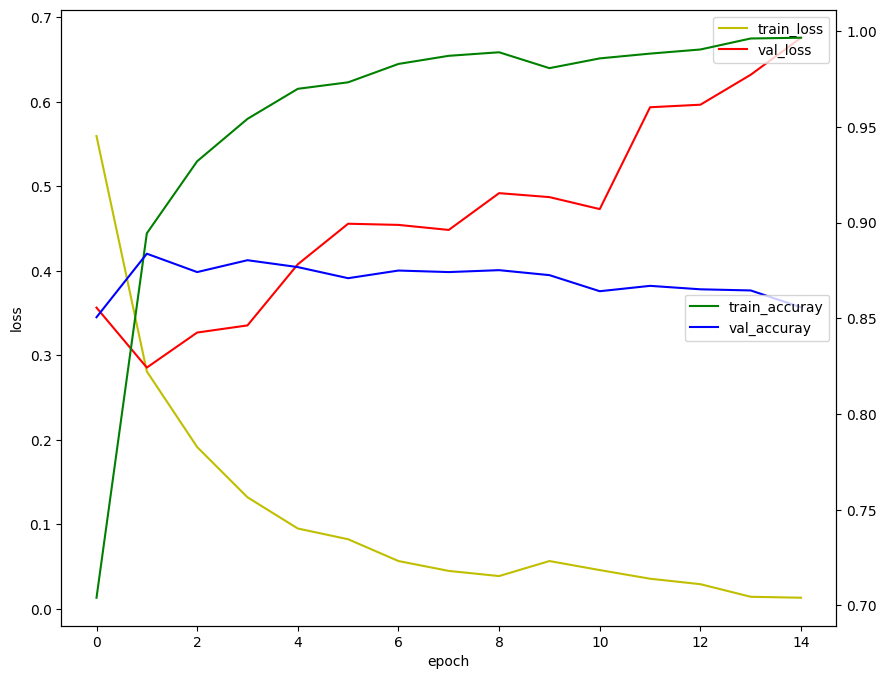

In [80]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,8))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x 축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuray')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuray')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='upper right')
acc_ax.legend(loc='center right')
plt.show()

In [81]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 11s 13ms/step - loss: 0.8269 - accuracy: 0.8267
test의 데이터 정확도 : 0.8267199993133545


In [24]:
# 모델 저장
model.save('imdb_v2.10_skip20length80.h5')

In [29]:
# 혼동행렬(교차표 평가성능지표)
# y_test # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
y_hat

782/782 [==============================] - 4s 6ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [33]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [34]:
# 실제값과 예측값의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[ 8236,  4264],
       [ 1536, 10964]], dtype=int64)

In [35]:
# 실제값과 예측값의 차원이 같아야 함
pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0,8236,4264
1,1536,10964


In [36]:
# accuracy, precision, recall, f1 score
print('acc :', acc)
print('precision :', precision_score(y_test, y_hat))
print('recall :', recall_score(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

acc : 0.7680000066757202
precision : 0.7199894930391384
recall : 0.87712
f1 score : 0.7908251586843623


In [41]:
import re
review = """It was good choice to see this movie today. The voice casting was great and thier acting was incredible. Few scenes were poorly performed but excluding 
those few scenes, I enjoyed the movie. I would recommend the movie to family with young kids. The animation was smooth. The scienario was fast pace. :)""".lower()
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()
print(review)

['it', 'was', 'good', 'choice', 'to', 'see', 'this', 'movie', 'today', 'the', 'voice', 'casting', 'was', 'great', 'and', 'thier', 'acting', 'was', 'incredible', 'few', 'scenes', 'were', 'poorly', 'performed', 'but', 'excluding', 'those', 'few', 'scenes', 'i', 'enjoyed', 'the', 'movie', 'i', 'would', 'recommend', 'the', 'movie', 'to', 'family', 'with', 'young', 'kids', 'the', 'animation', 'was', 'smooth', 'the', 'scienario', 'was', 'fast', 'pace']


In [52]:
data = [1]+[word_to_id.get(r,-1)+3 for r in review]
data = [2 if (d<=SKIP_TOP) | (d>MY_WORDS) else d for d in data ]
print(data, len(data))

[2, 2, 2, 52, 2, 2, 67, 2, 2, 639, 2, 544, 973, 2, 87, 2, 2, 116, 2, 2, 171, 139, 71, 862, 2, 21, 2, 148, 171, 139, 2, 510, 2, 2, 2, 62, 386, 2, 2, 2, 223, 2, 185, 362, 2, 748, 2, 2, 2, 2, 2, 702, 2] 53


In [56]:
input_data = pad_sequences(sequences=[data], maxlen=MY_LENGTH, padding='pre', truncating='pre')
print(input_data)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2   2   2  52   2   2  67   2   2
  639   2 544 973   2  87   2   2 116   2   2 171 139  71 862   2  21   2
  148 171 139   2 510   2   2   2  62 386   2   2   2 223   2 185 362   2
  748   2   2   2   2   2 702   2]]


In [57]:
model.predict(input_data)

1/1 [==============================] - 0s 124ms/step


array([[0.63989407]], dtype=float32)

In [58]:
review = """One of the terrific movie I have ever seen. Bullshit is the only word to describte the movie.
It was waste of time watching this 2 hours. I do not get any storyline and
it does not seem to be connected. I don't understand what the movie wanst to tell.
Actors were great but the story destroyed everything. I feel bad for those actors. 
I would recommend the movie to those who wants to waste time."""
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()
data = [1]+[word_to_id.get(r,-1)+3 for r in review]
data = [2 if (d<=SKIP_TOP) | (d>MY_WORDS) else d for d in data ]
input_data = pad_sequences(sequences=[data], maxlen=MY_LENGTH, padding='pre', truncating='pre')
print(input_data)

[[  0   0   2   2   2   2   2   2   2  28 126 110   2   2   2  64 681   2
    2   2   2   2   2 437   2  58 149   2 241 634   2  81  24  79 101 769
    2   2 127  24 306   2  30   2   2   2 830 391  51   2   2   2   2 376
    2  71  87  21   2  65   2 285   2 235  78   2 148 156   2  62 386   2
    2   2 148  37 494   2 437  58]]


In [59]:
model.predict(input_data)

1/1 [==============================] - 0s 82ms/step


array([[0.03556566]], dtype=float32)